In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score

## Functions for loading Train and Test Data

In [3]:
class_names={0:'aquarium',1:'desert',2:'highway',3:'kitchen',4:'laundromat',
             5:'park',6:'waterfall',7:'windmill'}

In [4]:
def load_data(p):
    train_data=[]
    train_labels=[]
    path=os.path.join(os.getcwd(),os.pardir,'dataset','SUN_data',p)
    names=[]
    for name in glob.glob(os.path.join(path,'*')):
        names.append(name)
    names=sorted(names)
    for i in range(len(names)):
        for img_name in glob.glob(os.path.join(names[i],'*')):
            img=cv2.imread(img_name)
            img=cv2.resize(img,(150,150))
            train_data.append(img)
            train_labels.append(i)
    return np.array(train_data),np.array(train_labels)

## Shapes of Train and Test Data

In [5]:
X_train,y_train=load_data('train')
X_test,y_test=load_data('test')
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(640, 150, 150, 3) (640,) (160, 150, 150, 3) (160,)


## Function for extracting descriptors from a single Image

In [6]:
extractor=cv2.xfeatures2d.SIFT_create()
def get_features(image):
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return descriptors

## Function for stacking up descriptors of whole Data

In [7]:
def get_descriptors(X):
    descriptors=get_features(X[0])
    des_shapes=[]
    des_shapes.append(descriptors.shape[0])
    for img in X[1:]:
        temp=get_features(img)
        des_shapes.append(temp.shape[0])
        descriptors=np.concatenate((descriptors,temp))
    return descriptors,des_shapes

## Function for creating histograms of Images from trained K-MEANS Clusters

In [8]:
def compute_hist(X,num_clusters,des_shapes,all_labels,std=None,normalise=True):
    hist=np.zeros((X.shape[0],num_clusters)).astype(np.float32)
    start=0
    for i in range(len(des_shapes)):
        end=start+des_shapes[i]
        labels=all_labels[start:end]
        for label in labels:
            hist[i][label]+=1
        start=end
    if normalise is True:
        if std is None:
            std = StandardScaler().fit(hist)
        hist = std.transform(hist)
    return hist,std

## Function for executing the main code

In [9]:
def execute(normalise,num_clusters=100):
    print("Running.....")
    print("Descriptors being accumulated from train data...")
    descriptors,des_shapes=get_descriptors(X_train)
    print("Data being fit  into Kmeans....")
    kmeans=KMeans(n_clusters=num_clusters,random_state=0).fit(descriptors)
    print("Histograms being created for train images")
    hist_train,std=compute_hist(X_train,num_clusters,des_shapes,kmeans.labels_,None,normalise)
    
    print("Training SVM from histogram data...")
    #Default Method is one (vs) rest.Hence,no need to mention explicitly
    clf = LinearSVC(max_iter=100000,C=0.001) 
    clf.fit(hist_train, y_train)
    
    print("Descriptors being accumulated from test data...")
    test_descriptors,test_des_shapes=get_descriptors(X_test)
    print("Predicting clusters from previously learnt k-means")
    all_labels=kmeans.predict(test_descriptors)
    print("Histograms being created for test images")
    hist_test,_=compute_hist(X_test,num_clusters,test_des_shapes,all_labels,std,normalise)
    
    print("Calculating Evaluation Metrics...\n")
    predictions =  clf.predict(hist_test)
    accuracy = accuracy_score(y_test, predictions)
    print (f"\nAccuracy = {accuracy}\n")
    cm = confusion_matrix(y_test, predictions)
    print (cm)
    plt.matshow(cm)
    plt.title('Confusion matrix\n')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()
    
    print("Plotting some sample Images....\n")
    num_images=10
    res=(y_test==predictions)
    inds=np.random.randint(low = 0, high = y_test.shape[0], size = num_images)
    fig=plt.figure(figsize=(30, 30))
    fig.subplots_adjust(hspace=0.6)

    for i in range(5):
        for j in range(2):
            ind=i*2+j+1
            image_ind=inds[ind-1]
            correct_class=class_names[y_test[image_ind]]
            predicted_class=class_names[predictions[image_ind]]
            title=f'Actcual class:{correct_class}\nPredicted class:{predicted_class}'
            colour=[0,255,0]
            if res[image_ind]==False:
                colour=[255,0,0]
            plt.subplot(5,2,ind)
            plt.axis("off")
            plt.title(title,fontsize= 30)
            img=X_test[image_ind]
            img=cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_CONSTANT,value=colour)
            plt.imshow(img)
    plt.show()
    return

## Running code with Normalisation

Running.....
Descriptors being accumulated from train data...
Data being fit  into Kmeans....
Histograms being created for train images
Training SVM from histogram data...
Descriptors being accumulated from test data...
Predicting clusters from previously learnt k-means
Histograms being created for test images
Calculating Evaluation Metrics...


Accuracy = 0.5

[[14  4  0  0  0  1  1  0]
 [ 1 15  0  0  2  0  1  1]
 [ 1  7  5  2  1  1  3  0]
 [ 3  2  0  9  4  0  1  1]
 [ 1  3  0  6 10  0  0  0]
 [ 1  1  0  0  0 14  1  3]
 [ 1  0  1  0  0  9  9  0]
 [ 1  5  3  1  1  3  2  4]]


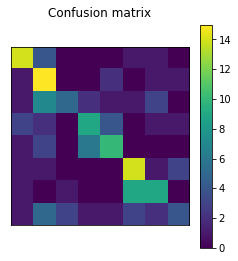

Plotting some sample Images....



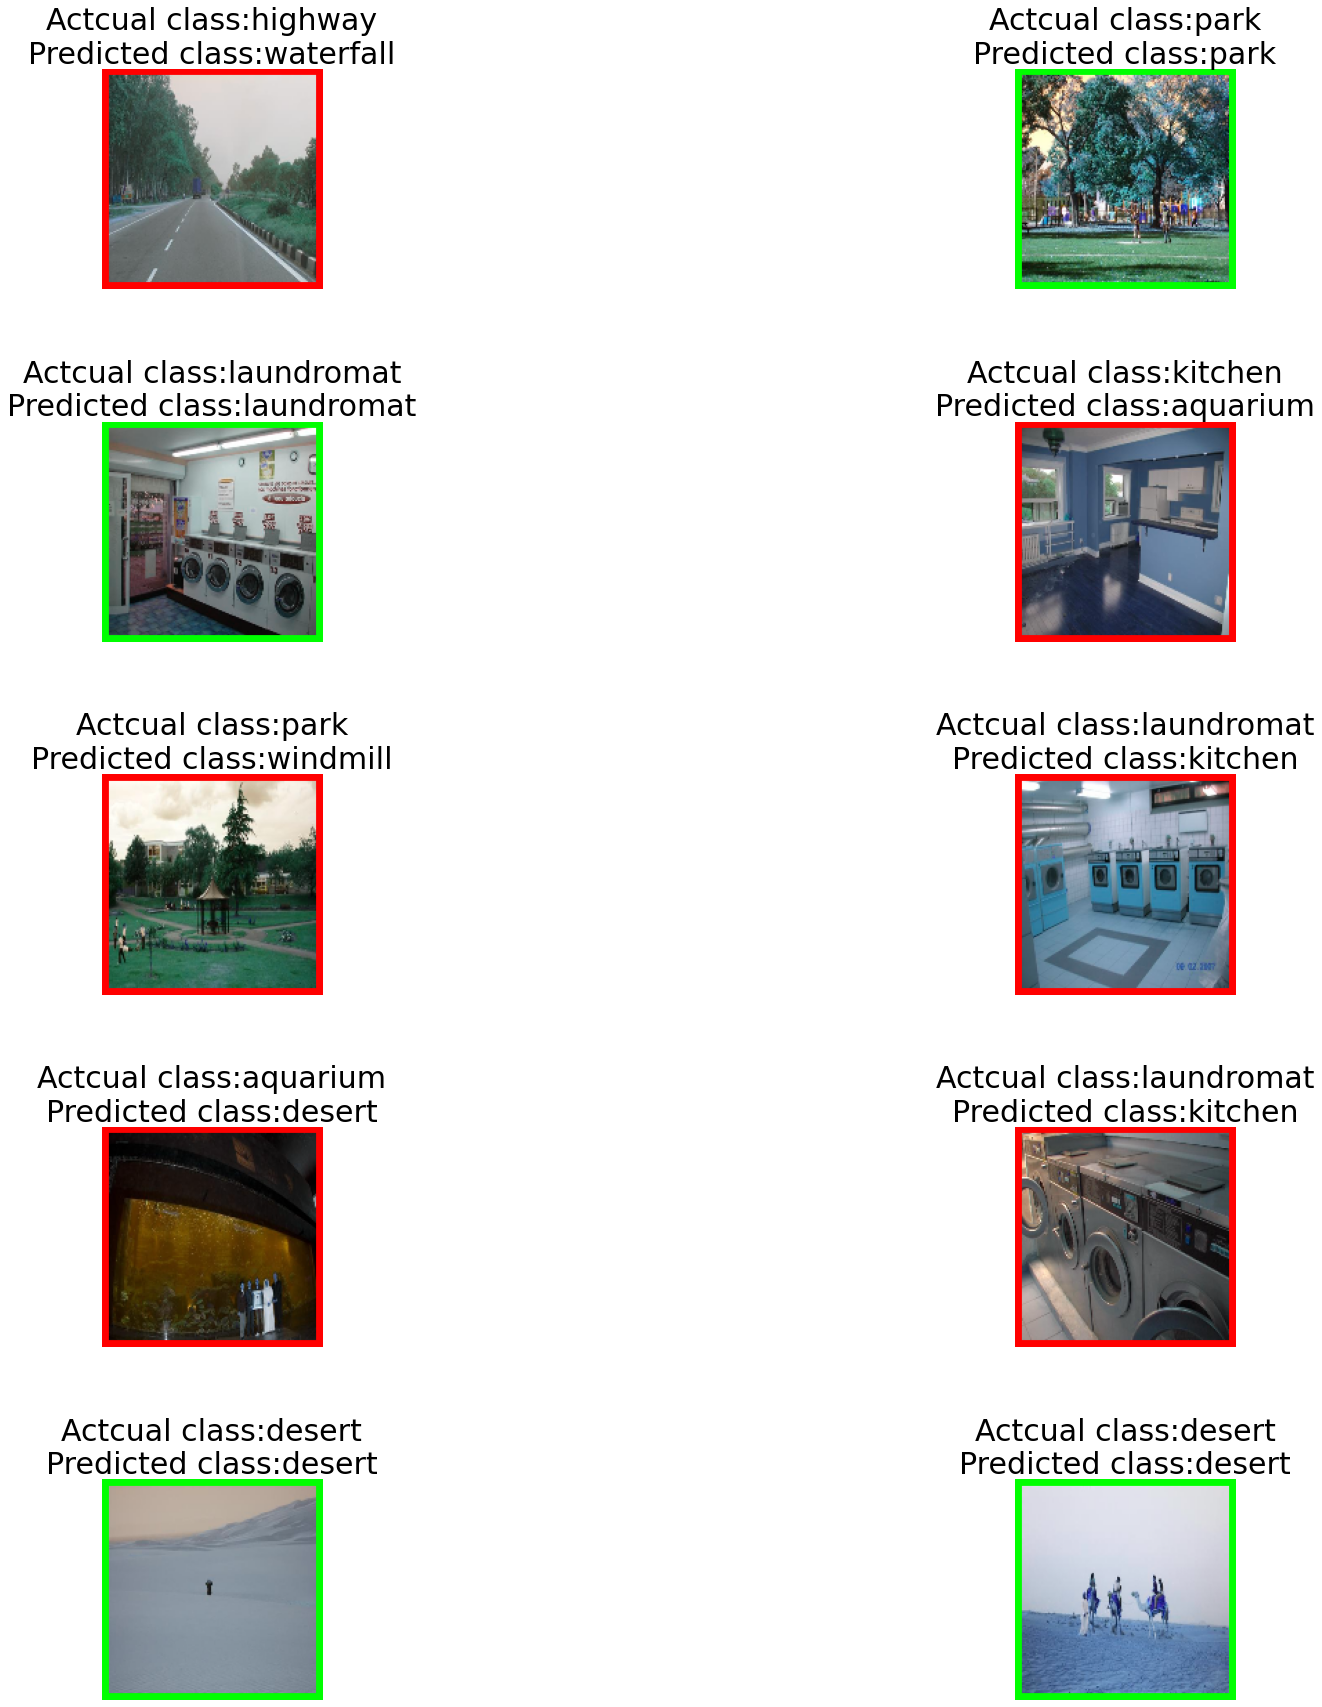

In [13]:
execute(True,num_clusters=100)

## Running code without Normalisation

Running.....
Descriptors being accumulated from train data...
Data being fit  into Kmeans....
Histograms being created for train images
Training SVM from histogram data...
Descriptors being accumulated from test data...
Predicting clusters from previously learnt k-means
Histograms being created for test images
Calculating Evaluation Metrics...


Accuracy = 0.49375

[[14  1  0  0  0  3  1  1]
 [ 0  9  1  0  2  0  5  3]
 [ 0  3  8  3  1  1  3  1]
 [ 3  0  2  9  3  0  1  2]
 [ 1  0  1  6 11  1  0  0]
 [ 0  1  0  0  1 14  1  3]
 [ 2  0  1  0  0  6 10  1]
 [ 0  2  4  1  1  5  3  4]]


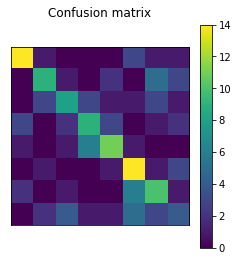

Plotting some sample Images....



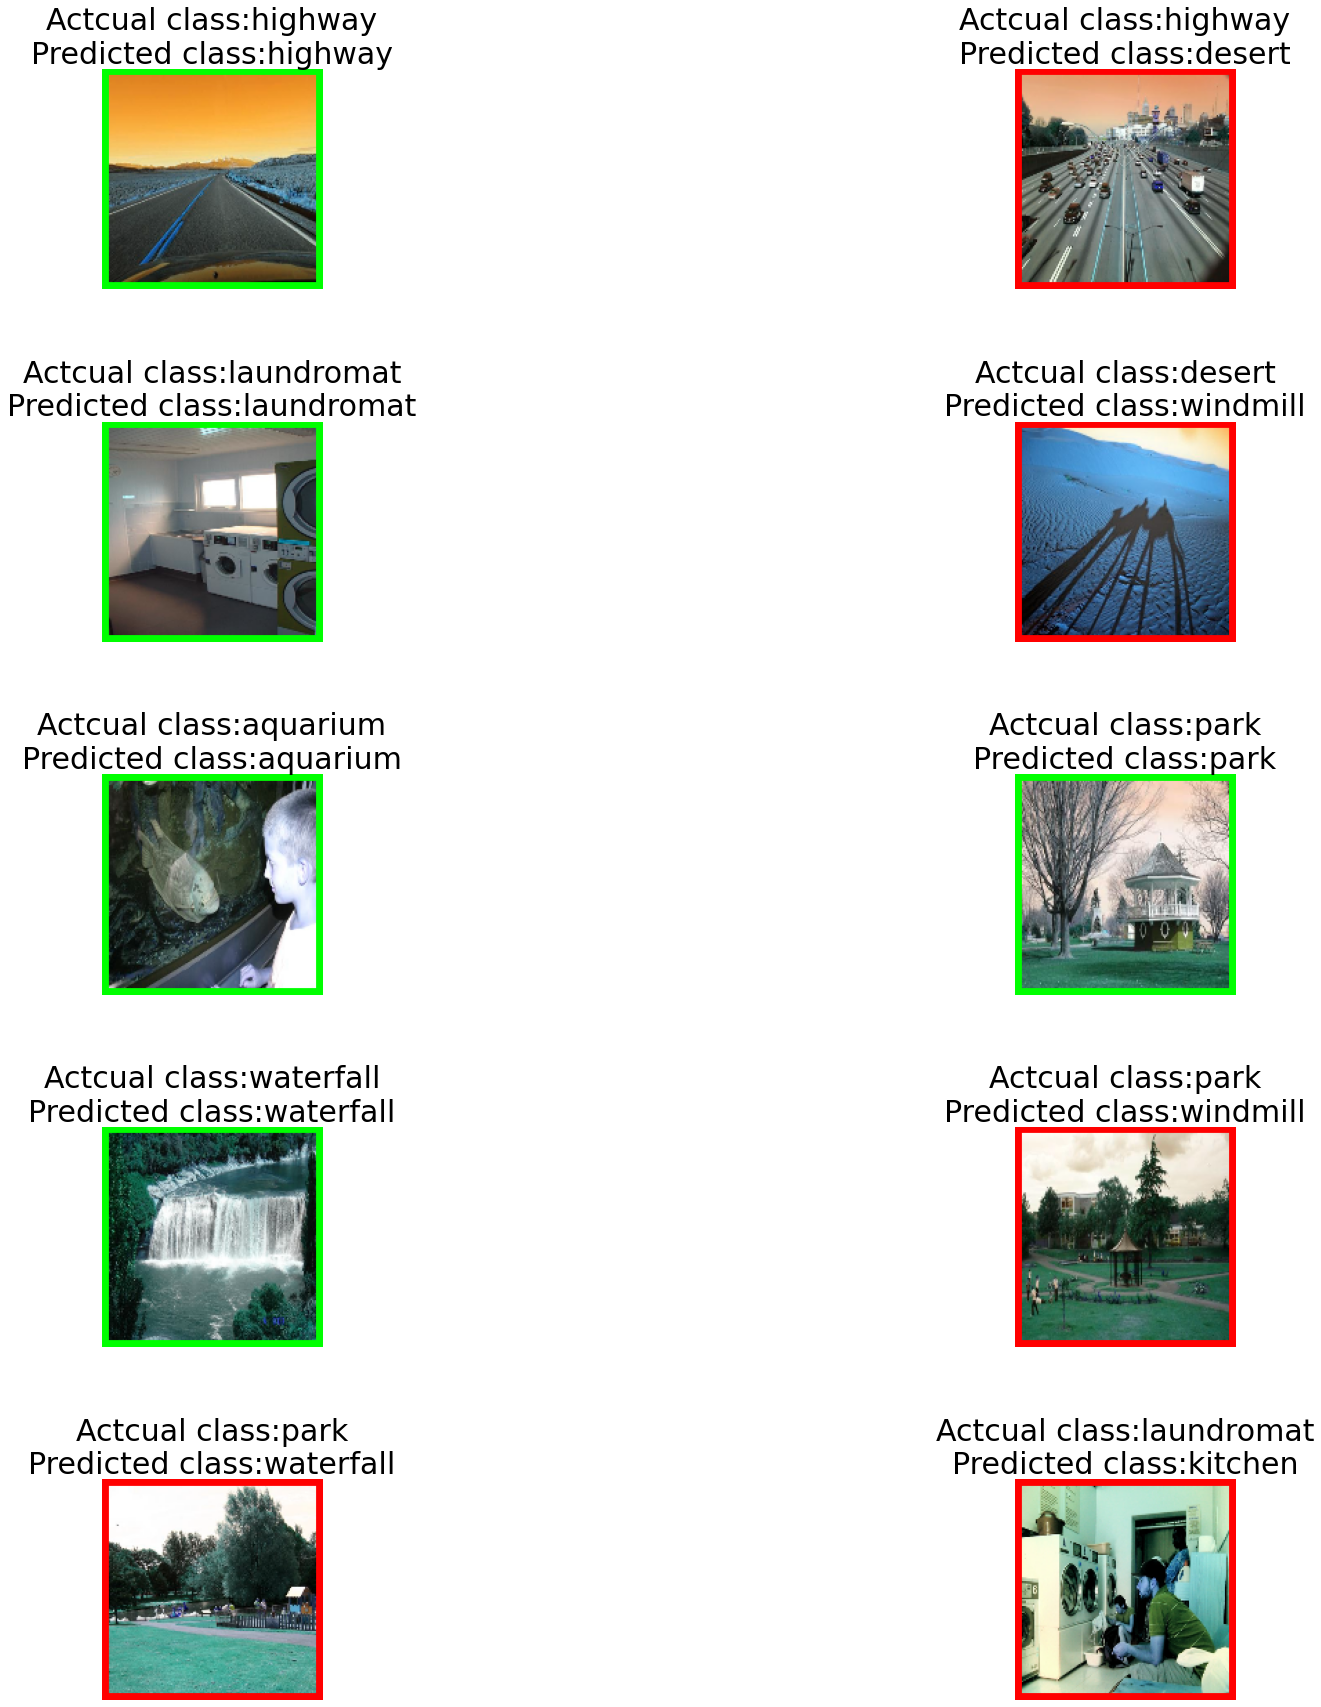

In [10]:
execute(False,num_clusters=100)

<h1><u>Observations</u></h1>

<ul>
    <li>Number of clusters=100</li>
    <li>C(regularisation parameter in SVM)=0.001</li>
</ul>

After trying out a few values,these seem to perform well.

Results didn't change by a huge amount in this case with/without Normalisation.Although,normalisation gave a slightly better result in this case.